In [1]:
import os
import torch
from tqdm.auto import tqdm

from models.ctm import ContinuousThoughtMachine
from utils.housekeeping import set_seed, zip_python_code
from utils.losses import image_classification_loss
from utils.schedulers import WarmupCosineAnnealingLR

from data import get_dataset

c:\Users\Rahul\miniconda3\envs\cuda124\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
log_dir = 'logs/custom_run'
data_root = 'dataset/'
batch_size = 32
batch_size_test = 32
lr = 1e-3
training_iterations = 10001
warmup_steps = 500
use_scheduler = True
scheduler_type = 'cosine'
milestones = [8000, 15000, 20000]
gamma = 0.1
weight_decay = 0.0
gradient_clipping = -1
num_workers_train = 1
num_workers_test = 1
save_every = 1000
seed = 412
track_every = 1000
n_test_batches = 20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
use_amp = False

In [3]:
d_model = 512
dropout = 0.0
backbone_type = 'resnet18-4'
d_input = 128
heads = 4
iterations = 75
positional_embedding_type = 'none'
synapse_depth = 4
n_synch_out = 512
n_synch_action = 512
neuron_select_type = 'random-pairing'
n_random_pairing_self = 0
memory_length = 25
deep_memory = True
memory_hidden_dims = 4
dropout_nlm = None
do_normalisation = False

In [4]:
set_seed(seed, False)
os.makedirs(log_dir, exist_ok=True)

In [5]:
train_data, test_data, class_labels, dataset_mean, dataset_std = get_dataset(data_root)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers_train)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True, num_workers=num_workers_test, drop_last=False)
prediction_reshaper = [-1]
out_dims = len(class_labels)

✅ Loaded mean/std from cache: mean_std_cache.json


In [6]:
zip_python_code(f'{log_dir}/repo_state.zip')
with open(f'{log_dir}/args.txt', 'w') as f:
    f.write(f"Custom run config\n")

In [7]:
device

'cuda:0'

In [8]:
model = ContinuousThoughtMachine(
    iterations=iterations,
    d_model=d_model,
    d_input=d_input,
    heads=heads,
    n_synch_out=n_synch_out,
    n_synch_action=n_synch_action,
    synapse_depth=synapse_depth,
    memory_length=memory_length,
    deep_nlms=deep_memory,
    memory_hidden_dims=memory_hidden_dims,
    do_layernorm_nlm=do_normalisation,
    backbone_type=backbone_type,
    positional_embedding_type=positional_embedding_type,
    out_dims=out_dims,
    prediction_reshaper=prediction_reshaper,
    dropout=dropout,
    dropout_nlm=dropout_nlm,
    neuron_select_type=neuron_select_type,
    n_random_pairing_self=n_random_pairing_self,
).to(device)

Using neuron select type: random-pairing
Synch representation size action: 512
Synch representation size out: 512


In [9]:
pseudo_inputs = train_data.__getitem__(0)[0].unsqueeze(0).to(device)
model(pseudo_inputs)
model.train()
print(f'Total params: {sum(p.numel() for p in model.parameters())}')

Total params: 12315870


In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = WarmupCosineAnnealingLR(optimizer, warmup_steps, training_iterations, warmup_start_lr=1e-20, eta_min=1e-7) if use_scheduler else None
scaler = torch.amp.GradScaler("cuda" if "cuda" in device else "cpu", enabled=use_amp)

In [11]:
for bi in tqdm(range(training_iterations)):
    try:
        inputs, targets = next(iterator)
    except:
        iterator = iter(trainloader)
        inputs, targets = next(iterator)
    inputs, targets = inputs.to(device), targets.to(device)

    optimizer.zero_grad(set_to_none=True)
    with torch.autocast(device_type="cuda" if "cuda" in device else "cpu", dtype=torch.float16, enabled=use_amp):
        predictions, certainties, _ = model(inputs)
        loss, where_most_certain = image_classification_loss(predictions, certainties, targets, use_most_certain=True)
    scaler.scale(loss).backward()
    if gradient_clipping != -1:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clipping)
    scaler.step(optimizer)
    scaler.update()
    if scheduler: scheduler.step()

    if bi % 100 == 0:
        acc = (predictions.argmax(1)[torch.arange(predictions.size(0), device=predictions.device), where_most_certain] == targets).float().mean().item()
        print(f"Iter {bi}: Loss={loss.item():.4f}, Acc={acc:.4f}")

    if bi % save_every == 0 and bi > 0:
        torch.save({'model_state_dict': model.state_dict()}, f'{log_dir}/checkpoint_{bi}.pt')

  0%|          | 1/10001 [00:06<18:33:19,  6.68s/it]

Iter 0: Loss=1.3845, Acc=0.3125


  1%|          | 101/10001 [02:00<3:22:20,  1.23s/it]

Iter 100: Loss=0.7863, Acc=0.6562


  2%|▏         | 201/10001 [03:58<3:20:32,  1.23s/it]

Iter 200: Loss=0.9198, Acc=0.5625


  3%|▎         | 301/10001 [05:52<3:15:19,  1.21s/it]

Iter 300: Loss=0.6051, Acc=0.7500


  4%|▍         | 401/10001 [07:52<3:30:45,  1.32s/it]

Iter 400: Loss=0.4827, Acc=0.7812


  5%|▌         | 501/10001 [09:49<3:13:02,  1.22s/it]

Iter 500: Loss=0.3820, Acc=0.8125


  6%|▌         | 601/10001 [11:49<3:14:49,  1.24s/it]

Iter 600: Loss=0.3191, Acc=0.8125


  7%|▋         | 701/10001 [13:44<3:07:43,  1.21s/it]

Iter 700: Loss=0.5835, Acc=0.6875


  8%|▊         | 801/10001 [16:30<3:13:38,  1.26s/it]

Iter 800: Loss=0.2998, Acc=0.8750


  9%|▉         | 901/10001 [18:34<3:49:08,  1.51s/it]

Iter 900: Loss=0.2927, Acc=0.8125


 10%|█         | 1001/10001 [20:31<3:06:19,  1.24s/it]

Iter 1000: Loss=0.3177, Acc=0.7812


 11%|█         | 1101/10001 [22:31<2:41:54,  1.09s/it]

Iter 1100: Loss=0.4779, Acc=0.6875


 12%|█▏        | 1201/10001 [24:18<3:11:04,  1.30s/it]

Iter 1200: Loss=0.2205, Acc=0.8750


 13%|█▎        | 1301/10001 [26:14<2:48:54,  1.16s/it]

Iter 1300: Loss=0.2050, Acc=0.8750


 14%|█▍        | 1401/10001 [28:11<2:47:45,  1.17s/it]

Iter 1400: Loss=0.4236, Acc=0.7812


 15%|█▌        | 1501/10001 [30:03<2:39:15,  1.12s/it]

Iter 1500: Loss=0.1124, Acc=0.9688


 16%|█▌        | 1601/10001 [31:45<2:34:04,  1.10s/it]

Iter 1600: Loss=0.3049, Acc=0.8125


 17%|█▋        | 1701/10001 [33:33<2:33:31,  1.11s/it]

Iter 1700: Loss=0.2462, Acc=0.8750


 18%|█▊        | 1801/10001 [35:25<2:36:21,  1.14s/it]

Iter 1800: Loss=0.2868, Acc=0.8750


 19%|█▉        | 1901/10001 [37:09<2:36:28,  1.16s/it]

Iter 1900: Loss=0.1696, Acc=0.9062


 20%|██        | 2001/10001 [39:03<2:47:38,  1.26s/it]

Iter 2000: Loss=0.2909, Acc=0.8438


 21%|██        | 2101/10001 [41:00<2:41:52,  1.23s/it]

Iter 2100: Loss=0.2789, Acc=0.9062


 22%|██▏       | 2201/10001 [43:00<2:36:22,  1.20s/it]

Iter 2200: Loss=0.1851, Acc=0.9062


 23%|██▎       | 2301/10001 [44:59<3:33:53,  1.67s/it]

Iter 2300: Loss=0.4076, Acc=0.8438


 24%|██▍       | 2401/10001 [47:03<2:49:27,  1.34s/it]

Iter 2400: Loss=0.1045, Acc=0.9688


 25%|██▌       | 2501/10001 [49:00<2:30:11,  1.20s/it]

Iter 2500: Loss=0.2441, Acc=0.8438


 26%|██▌       | 2601/10001 [50:57<2:31:13,  1.23s/it]

Iter 2600: Loss=0.3578, Acc=0.7812


 27%|██▋       | 2701/10001 [52:52<2:25:40,  1.20s/it]

Iter 2700: Loss=0.3110, Acc=0.8125


 28%|██▊       | 2801/10001 [54:42<2:21:01,  1.18s/it]

Iter 2800: Loss=0.1147, Acc=0.9375


 29%|██▉       | 2901/10001 [56:36<2:18:13,  1.17s/it]

Iter 2900: Loss=0.1368, Acc=0.8750


 30%|███       | 3001/10001 [58:24<2:19:02,  1.19s/it]

Iter 3000: Loss=0.2361, Acc=0.9062


 31%|███       | 3101/10001 [1:00:23<2:14:15,  1.17s/it]

Iter 3100: Loss=0.0268, Acc=1.0000


 32%|███▏      | 3201/10001 [1:02:14<2:08:31,  1.13s/it]

Iter 3200: Loss=0.1761, Acc=0.8750


 33%|███▎      | 3301/10001 [1:04:08<2:14:16,  1.20s/it]

Iter 3300: Loss=0.1867, Acc=0.8750


 34%|███▍      | 3401/10001 [1:05:58<2:02:06,  1.11s/it]

Iter 3400: Loss=0.2062, Acc=0.8750


 35%|███▌      | 3501/10001 [1:07:53<2:08:31,  1.19s/it]

Iter 3500: Loss=0.1239, Acc=0.9375


 36%|███▌      | 3601/10001 [1:09:48<2:05:49,  1.18s/it]

Iter 3600: Loss=0.1541, Acc=0.9375


 37%|███▋      | 3701/10001 [1:11:39<2:03:43,  1.18s/it]

Iter 3700: Loss=0.1370, Acc=0.9062


 38%|███▊      | 3801/10001 [1:13:34<2:03:52,  1.20s/it]

Iter 3800: Loss=0.1903, Acc=0.9062


 39%|███▉      | 3901/10001 [1:15:25<2:02:11,  1.20s/it]

Iter 3900: Loss=0.1348, Acc=0.9062


 40%|████      | 4001/10001 [1:17:19<1:59:54,  1.20s/it]

Iter 4000: Loss=0.0230, Acc=1.0000


 41%|████      | 4101/10001 [1:19:10<1:55:28,  1.17s/it]

Iter 4100: Loss=0.1789, Acc=0.8750


 42%|████▏     | 4201/10001 [1:21:05<1:54:22,  1.18s/it]

Iter 4200: Loss=0.2200, Acc=0.8750


 43%|████▎     | 4301/10001 [1:22:59<2:23:10,  1.51s/it]

Iter 4300: Loss=0.0993, Acc=0.9688


 44%|████▍     | 4401/10001 [1:24:50<1:50:00,  1.18s/it]

Iter 4400: Loss=0.0760, Acc=0.9688


 45%|████▌     | 4501/10001 [1:26:45<1:46:08,  1.16s/it]

Iter 4500: Loss=0.2135, Acc=0.9375


 46%|████▌     | 4601/10001 [1:28:36<1:50:13,  1.22s/it]

Iter 4600: Loss=0.0524, Acc=0.9688


 47%|████▋     | 4701/10001 [1:30:31<1:44:57,  1.19s/it]

Iter 4700: Loss=0.1183, Acc=0.9375


 48%|████▊     | 4801/10001 [1:32:22<1:43:58,  1.20s/it]

Iter 4800: Loss=0.0971, Acc=0.9375


 49%|████▉     | 4901/10001 [1:34:18<1:40:47,  1.19s/it]

Iter 4900: Loss=0.2189, Acc=0.8750


 50%|█████     | 5001/10001 [1:36:10<1:39:32,  1.19s/it]

Iter 5000: Loss=0.1203, Acc=0.9375


 51%|█████     | 5101/10001 [1:38:05<1:36:22,  1.18s/it]

Iter 5100: Loss=0.1594, Acc=0.9062


 52%|█████▏    | 5201/10001 [1:39:59<1:35:56,  1.20s/it]

Iter 5200: Loss=0.1297, Acc=0.9375


 53%|█████▎    | 5301/10001 [1:41:48<1:29:29,  1.14s/it]

Iter 5300: Loss=0.0821, Acc=0.9375


 54%|█████▍    | 5401/10001 [1:43:46<1:28:39,  1.16s/it]

Iter 5400: Loss=0.0860, Acc=0.9375


 55%|█████▌    | 5501/10001 [1:45:36<1:29:43,  1.20s/it]

Iter 5500: Loss=0.0700, Acc=0.9688


 56%|█████▌    | 5601/10001 [1:47:35<1:28:21,  1.20s/it]

Iter 5600: Loss=0.0627, Acc=0.9688


 57%|█████▋    | 5701/10001 [1:49:30<1:31:10,  1.27s/it]

Iter 5700: Loss=0.0995, Acc=0.9375


 58%|█████▊    | 5801/10001 [1:51:30<1:25:47,  1.23s/it]

Iter 5800: Loss=0.0410, Acc=0.9688


 59%|█████▉    | 5901/10001 [1:53:23<1:24:56,  1.24s/it]

Iter 5900: Loss=0.0138, Acc=1.0000


 60%|██████    | 6001/10001 [1:55:23<1:18:12,  1.17s/it]

Iter 6000: Loss=0.0429, Acc=0.9688


 61%|██████    | 6101/10001 [1:57:24<1:25:08,  1.31s/it]

Iter 6100: Loss=0.0127, Acc=1.0000


 62%|██████▏   | 6201/10001 [1:59:18<1:15:41,  1.20s/it]

Iter 6200: Loss=0.0938, Acc=0.9375


 63%|██████▎   | 6301/10001 [2:01:19<1:14:27,  1.21s/it]

Iter 6300: Loss=0.0652, Acc=0.9688


 64%|██████▍   | 6401/10001 [2:03:11<1:15:00,  1.25s/it]

Iter 6400: Loss=0.0738, Acc=0.9688


 65%|██████▌   | 6501/10001 [2:05:08<1:09:49,  1.20s/it]

Iter 6500: Loss=0.0077, Acc=1.0000


 66%|██████▌   | 6601/10001 [2:06:57<1:06:27,  1.17s/it]

Iter 6600: Loss=0.0259, Acc=1.0000


 67%|██████▋   | 6701/10001 [2:08:50<1:03:12,  1.15s/it]

Iter 6700: Loss=0.0788, Acc=0.9688


 68%|██████▊   | 6801/10001 [2:10:39<1:01:13,  1.15s/it]

Iter 6800: Loss=0.0116, Acc=1.0000


 69%|██████▉   | 6901/10001 [2:12:33<59:54,  1.16s/it]  

Iter 6900: Loss=0.0085, Acc=1.0000


 70%|███████   | 7001/10001 [2:14:26<58:26,  1.17s/it]  

Iter 7000: Loss=0.0392, Acc=0.9688


 71%|███████   | 7101/10001 [2:16:15<56:55,  1.18s/it]  

Iter 7100: Loss=0.0563, Acc=0.9688


 72%|███████▏  | 7201/10001 [2:18:08<54:22,  1.17s/it]  

Iter 7200: Loss=0.0069, Acc=1.0000


 73%|███████▎  | 7301/10001 [2:19:57<52:36,  1.17s/it]

Iter 7300: Loss=0.0041, Acc=1.0000


 74%|███████▍  | 7401/10001 [2:21:49<50:00,  1.15s/it]  

Iter 7400: Loss=0.0904, Acc=0.9688


 75%|███████▌  | 7501/10001 [2:23:38<48:26,  1.16s/it]

Iter 7500: Loss=0.0083, Acc=1.0000


 76%|███████▌  | 7601/10001 [2:25:31<47:08,  1.18s/it]  

Iter 7600: Loss=0.0088, Acc=1.0000


 77%|███████▋  | 7701/10001 [2:27:24<1:02:01,  1.62s/it]

Iter 7700: Loss=0.0031, Acc=1.0000


 78%|███████▊  | 7801/10001 [2:29:14<42:52,  1.17s/it]  

Iter 7800: Loss=0.0025, Acc=1.0000


 79%|███████▉  | 7901/10001 [2:31:06<41:11,  1.18s/it]  

Iter 7900: Loss=0.0383, Acc=0.9688


 80%|████████  | 8001/10001 [2:32:55<39:06,  1.17s/it]

Iter 8000: Loss=0.0068, Acc=1.0000


 81%|████████  | 8101/10001 [2:34:48<36:50,  1.16s/it]  

Iter 8100: Loss=0.0564, Acc=0.9688


 82%|████████▏ | 8201/10001 [2:36:37<35:43,  1.19s/it]

Iter 8200: Loss=0.0380, Acc=0.9688


 83%|████████▎ | 8301/10001 [2:38:31<33:04,  1.17s/it]  

Iter 8300: Loss=0.0836, Acc=0.9375


 84%|████████▍ | 8401/10001 [2:40:20<31:23,  1.18s/it]

Iter 8400: Loss=0.0127, Acc=1.0000


 85%|████████▌ | 8501/10001 [2:42:14<29:01,  1.16s/it]  

Iter 8500: Loss=0.0653, Acc=0.9375


 86%|████████▌ | 8601/10001 [2:44:07<29:00,  1.24s/it]

Iter 8600: Loss=0.0004, Acc=1.0000


 87%|████████▋ | 8701/10001 [2:45:55<24:39,  1.14s/it]

Iter 8700: Loss=0.0105, Acc=1.0000


 88%|████████▊ | 8801/10001 [2:47:48<23:09,  1.16s/it]

Iter 8800: Loss=0.0036, Acc=1.0000


 89%|████████▉ | 8901/10001 [2:49:38<21:39,  1.18s/it]

Iter 8900: Loss=0.0008, Acc=1.0000


 90%|█████████ | 9001/10001 [2:51:31<19:28,  1.17s/it]

Iter 9000: Loss=0.0941, Acc=0.9688


 91%|█████████ | 9101/10001 [2:53:20<17:24,  1.16s/it]

Iter 9100: Loss=0.0001, Acc=1.0000


 92%|█████████▏| 9201/10001 [2:55:13<15:20,  1.15s/it]

Iter 9200: Loss=0.0006, Acc=1.0000


 93%|█████████▎| 9301/10001 [2:57:02<13:47,  1.18s/it]

Iter 9300: Loss=0.0003, Acc=1.0000


 94%|█████████▍| 9401/10001 [2:58:56<11:20,  1.13s/it]

Iter 9400: Loss=0.0010, Acc=1.0000


 95%|█████████▌| 9501/10001 [3:00:50<09:40,  1.16s/it]

Iter 9500: Loss=0.0406, Acc=0.9688


 96%|█████████▌| 9601/10001 [3:02:40<07:57,  1.19s/it]

Iter 9600: Loss=0.0023, Acc=1.0000


 97%|█████████▋| 9701/10001 [3:04:33<05:54,  1.18s/it]

Iter 9700: Loss=0.0615, Acc=0.9688


 98%|█████████▊| 9801/10001 [3:06:24<03:54,  1.17s/it]

Iter 9800: Loss=0.0072, Acc=1.0000


 99%|█████████▉| 9901/10001 [3:08:16<01:57,  1.17s/it]

Iter 9900: Loss=0.0026, Acc=1.0000


100%|██████████| 10001/10001 [3:10:05<00:00,  1.14s/it]

Iter 10000: Loss=0.0010, Acc=1.0000


In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from models.ctm import ContinuousThoughtMachine as CTM
import urllib
from IPython.display import Image as IPyImage, display
from pprint import pprint
import numpy as np
import seaborn as sns
import os
import torch.nn.functional as F
from matplotlib import patheffects
from scipy import ndimage
import imageio
import mediapy
from tasks.image_classification.plotting import plot_neural_dynamics

In [13]:
model.eval()

ContinuousThoughtMachine(
  (initial_rgb): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

In [35]:
train_data.class_to_idx

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [48]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        predictions, certainties, _ = model(inputs)
        loss, where_most_certain = image_classification_loss(predictions, certainties, targets, use_most_certain=True)
        test_loss += loss.item() * inputs.size(0)
        pred = predictions.argmax(1)[torch.arange(predictions.size(0), device=predictions.device), where_most_certain]
        correct += (pred == targets).sum().item()
        total += targets.size(0)

avg_test_loss = test_loss / total
test_acc = correct / total
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.0156, Test Accuracy: 0.9962


In [ ]:
def make_gif(input_tensor, predictions, certainties, attention_tracking, ground_truth_target, dataset_mean, dataset_std, class_labels, gif_path):

    def find_island_centers(array_2d, threshold):
        """
        Finds the center of mass of each island (connected component > threshold)
        in a 2D array, weighted by the array's values.
        Returns list of (y, x) centers and list of areas.
        """
        binary_image = array_2d > threshold
        labeled_image, num_labels = ndimage.label(binary_image)
        centers = []
        areas = []
        # Calculate center of mass for each labeled island (label 0 is background)
        for i in range(1, num_labels + 1):
            island_mask = (labeled_image == i)
            total_mass = np.sum(array_2d[island_mask])
            if total_mass > 0:
                # Get coordinates for this island
                y_coords, x_coords = np.mgrid[:array_2d.shape[0], :array_2d.shape[1]]
                # Calculate weighted average for center
                x_center = np.average(x_coords[island_mask], weights=array_2d[island_mask])
                y_center = np.average(y_coords[island_mask], weights=array_2d[island_mask])
                centers.append((round(y_center, 4), round(x_center, 4)))
                areas.append(np.sum(island_mask)) # Area is the count of pixels in the island
        return centers, areas

    interp_mode = 'nearest'
    figscale = 0.85


    # predictions: (B, Classes, Steps), attention_tracking: (Steps*B*Heads, SeqLen)
    n_steps = predictions.size(-1)

    # --- Reshape Attention ---
    # Infer feature map size from model internals (assuming B=1)
    h_feat, w_feat = model.kv_features.shape[-2:]

    n_heads = attention_tracking.shape[2] 
    # Reshape to (Steps, Heads, H_feat, W_feat) assuming B=1
    attention_tracking = attention_tracking.reshape(n_steps, n_heads, h_feat, w_feat)

    # --- Setup for Plotting ---
    step_linspace = np.linspace(0, 1, n_steps) # For step colors
    # Define color maps
    cmap_spectral = sns.color_palette("Spectral", as_cmap=True)
    cmap_attention = sns.color_palette('viridis', as_cmap=True)

    frames = [] # Store frames for GIF
    head_routes = {h: [] for h in range(n_heads)} # Store (y,x) path points per head
    head_routes[-1] = []
    route_colours_step = [] # Store colors for each step's path segments

    # --- Loop Through Each Step ---
    for step_i in range(n_steps):

        # --- Prepare Image for Display ---
        # Denormalize the input tensor for visualization
        data_img_tensor = input_tensor[0].cpu() # Get first item in batch, move to CPU
        mean_tensor = torch.tensor(dataset_mean).view(3, 1, 1)
        std_tensor = torch.tensor(dataset_std).view(3, 1, 1)
        data_img_denorm = data_img_tensor * std_tensor + mean_tensor
        # Permute to (H, W, C) and convert to numpy, clip to [0, 1]
        data_img_np = data_img_denorm.permute(1, 2, 0).detach().numpy()
        data_img_np = np.clip(data_img_np, 0, 1)
        img_h, img_w = data_img_np.shape[:2]

        # --- Process Attention & Certainty ---
        # Average attention over last few steps (from original code)
        start_step = max(0, step_i - 5)
        attention_now = attention_tracking[start_step : step_i + 1].mean(0) # Avg over steps -> (Heads, H_feat, W_feat)
        # Get certainties up to current step
        certainties_now = certainties[0, 1, :step_i+1].detach().cpu().numpy() # Assuming index 1 holds relevant certainty

        # --- Calculate Attention Paths (using bilinear interp) ---
        # Interpolate attention to image size using bilinear for center finding
        attention_interp_bilinear = F.interpolate(
            torch.from_numpy(attention_now).unsqueeze(0).float(), # Add batch dim, ensure float
            size=(img_h, img_w),
            mode=interp_mode,
            # align_corners=False
        ).squeeze(0) # Remove batch dim -> (Heads, H, W)

        # Normalize each head's map to [0, 1]
        # Deal with mean
        attn_mean = attention_interp_bilinear.mean(0)
        attn_mean_min = attn_mean.min()
        attn_mean_max = attn_mean.max()
        attn_mean = (attn_mean - attn_mean_min) / (attn_mean_max - attn_mean_min)
        centers, areas = find_island_centers(attn_mean.detach().cpu().numpy(), threshold=0.7)

        if centers: # If islands found
            largest_island_idx = np.argmax(areas)
            current_center = centers[largest_island_idx] # (y, x)
            head_routes[-1].append(current_center)
        elif head_routes[-1]: # If no center now, repeat last known center if history exists
            head_routes[-1].append(head_routes[-1][-1])


        attn_min = attention_interp_bilinear.view(n_heads, -1).min(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attn_max = attention_interp_bilinear.view(n_heads, -1).max(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attention_interp_bilinear = (attention_interp_bilinear - attn_min) / (attn_max - attn_min + 1e-6)

        # Store step color
        current_colour = list(cmap_spectral(step_linspace[step_i]))
        route_colours_step.append(current_colour)

        # Find island center for each head
        for head_i in range(n_heads):
            attn_head_np = attention_interp_bilinear[head_i].detach().cpu().numpy()
            # Keep threshold=0.7 based on original call
            centers, areas = find_island_centers(attn_head_np, threshold=0.7)

            if centers: # If islands found
                largest_island_idx = np.argmax(areas)
                current_center = centers[largest_island_idx] # (y, x)
                head_routes[head_i].append(current_center)
            elif head_routes[head_i]: # If no center now, repeat last known center if history exists
                    head_routes[head_i].append(head_routes[head_i][-1])
        
                

        # --- Plotting Setup ---
        mosaic = [['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                    ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                    ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                    ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                ['head_0', 'head_0_overlay', 'head_1', 'head_1_overlay', 'head_2', 'head_2_overlay', 'head_3', 'head_3_overlay'],
                ['head_4', 'head_4_overlay', 'head_5', 'head_5_overlay','head_6', 'head_6_overlay', 'head_7', 'head_7_overlay'],
                ['head_8', 'head_8_overlay', 'head_9', 'head_9_overlay','head_10', 'head_10_overlay', 'head_11', 'head_11_overlay'],
                ['head_12', 'head_12_overlay', 'head_13', 'head_13_overlay','head_14', 'head_14_overlay', 'head_15', 'head_15_overlay'],
                ['probabilities', 'probabilities','probabilities', 'probabilities', 'certainty', 'certainty', 'certainty', 'certainty'],
                ]

        img_aspect = data_img_np.shape[0] / data_img_np.shape[1]
        aspect_ratio = (8 * figscale, 9 * figscale * img_aspect) # W, H
        fig, axes = plt.subplot_mosaic(mosaic, figsize=aspect_ratio)

        for ax in axes.values():
            ax.axis('off')

        # --- Plot Certainty ---
        ax_cert = axes['certainty']
        ax_cert.plot(np.arange(len(certainties_now)), certainties_now, 'k-', linewidth=figscale*1)
        # Add background color based on prediction correctness at each step
        for ii in range(len(certainties_now)):
            is_correct = predictions[0, :, ii].argmax(-1).item() == ground_truth_target # .item() for scalar tensor
            facecolor = 'limegreen' if is_correct else 'orchid'
            ax_cert.axvspan(ii, ii + 1, facecolor=facecolor, edgecolor=None, lw=0, alpha=0.3)
        # Mark the last point
        ax_cert.plot(len(certainties_now)-1, certainties_now[-1], 'k.', markersize=figscale*4)
        ax_cert.axis('off')
        ax_cert.set_ylim([0.05, 1.05])
        ax_cert.set_xlim([0, n_steps]) # Use n_steps for consistent x-axis limit

        # --- Plot Probabilities ---
        ax_prob = axes['probabilities']
        # Get probabilities for the current step
        ps = torch.softmax(predictions[0, :, step_i], -1).detach().cpu()
        k = 4 # Top k predictions
        topk_probs, topk_indices = torch.topk(ps, k, dim=0, largest=True)
        topk_indices = topk_indices.numpy()
        topk_probs = topk_probs.numpy()

        true_class_idx = ground_truth_target # Ground truth index

        # Determine bar colors (green if correct, blue otherwise - consistent with original)
        colours = ['g' if idx == true_class_idx else 'b' for idx in topk_indices]

        # Plot horizontal bars (inverted range for top-down display)
        ax_prob.barh(np.arange(k)[::-1], topk_probs, color=colours, alpha=1) # Use barh and inverted range
        ax_prob.set_xlim([0, 1])
        ax_prob.axis('off')

        # Add text labels for top classes
        for i, name_idx in enumerate(topk_indices):
            name = class_labels[name_idx] # Get name from index
            is_correct = name_idx == true_class_idx
            fg_color = 'darkgreen' if is_correct else 'crimson' # Text colors from original
            text_str = f'{name[:40]}' # Truncate long names
            # Position text on the left side of the horizontal bars
            ax_prob.text(
                0.01, # Small offset from left edge
                k - 1 - i, # Y-position corresponding to the bar
                text_str,
                #transform=ax_prob.transAxes, # Use data coordinates for Y
                verticalalignment='center',
                horizontalalignment='left',
                fontsize=8,
                color=fg_color,
                alpha=0.9, # Slightly more visible than 0.5
                path_effects=[
                    patheffects.Stroke(linewidth=2, foreground='white'), # Adjusted stroke
                    patheffects.Normal()
                ])


        # --- Plot Attention Heads & Overlays (using nearest interp) ---
        # Re-interpolate attention using nearest neighbor for visual plotting
        attention_interp_plot = F.interpolate(
            torch.from_numpy(attention_now).unsqueeze(0).float(),
            size=(img_h, img_w),
            mode=interp_mode, # 'nearest'
        ).squeeze(0)

        attn_mean = attention_interp_plot.mean(0)
        attn_mean_min = attn_mean.min()
        attn_mean_max = attn_mean.max()
        attn_mean = (attn_mean - attn_mean_min) / (attn_mean_max - attn_mean_min)


        # Normalize each head's map to [0, 1]
        attn_min_plot = attention_interp_plot.view(n_heads, -1).min(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attn_max_plot = attention_interp_plot.view(n_heads, -1).max(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attention_interp_plot = (attention_interp_plot - attn_min_plot) / (attn_max_plot - attn_min_plot + 1e-6)
        attention_interp_plot_np = attention_interp_plot.detach().cpu().numpy()
        


        


        for head_i in list(range(n_heads)) + [-1]:
            axname = f'head_{head_i}' if head_i != -1 else 'head_mean'
            if axname not in axes: continue # Skip if mosaic doesn't have this head

            ax = axes[axname]
            ax_overlay = axes[f'{axname}_overlay']

            # Plot attention heatmap
            this_attn = attention_interp_plot_np[head_i] if head_i != -1 else attn_mean
            img_to_plot = cmap_attention(this_attn)
            ax.imshow(img_to_plot)
            ax.axis('off')

            # Plot overlay: image + paths
            these_route_steps = head_routes[head_i]
            arrow_scale = 1.5 if head_i != -1 else 3

            if these_route_steps: # Only plot if path exists
                # Separate y and x coordinates
                y_coords, x_coords = zip(*these_route_steps)
                y_coords = np.array(y_coords)
                x_coords = np.array(x_coords)

                # Flip y-coordinates for correct plotting (imshow origin is top-left)
                # NOTE: Original flip seemed complex, simplifying to standard flip
                y_coords_flipped = img_h - 1 - y_coords

                # Show original image flipped vertically to match coordinate system
                ax_overlay.imshow(np.flipud(data_img_np), origin='lower')

                # Draw arrows for path segments
                    # Arrow size scaling from original
                for i in range(len(these_route_steps) - 1):
                    dx = x_coords[i+1] - x_coords[i]
                    dy = y_coords_flipped[i+1] - y_coords_flipped[i] # Use flipped y for delta

                    # Draw white background arrow (thicker)
                    ax_overlay.arrow(x_coords[i], y_coords_flipped[i], dx, dy,
                                        linewidth=1.6 * arrow_scale * 1.3,
                                        head_width=1.9 * arrow_scale * 1.3,
                                        head_length=1.4 * arrow_scale * 1.45,
                                        fc='white', ec='white', length_includes_head=True, alpha=1)
                    # Draw colored foreground arrow
                    ax_overlay.arrow(x_coords[i], y_coords_flipped[i], dx, dy,
                                        linewidth=1.6 * arrow_scale,
                                        head_width=1.9 * arrow_scale,
                                        head_length=1.4 * arrow_scale,
                                        fc=route_colours_step[i], ec=route_colours_step[i], # Use step color
                                        length_includes_head=True)

            else: # If no path yet, just show the image
                    ax_overlay.imshow(np.flipud(data_img_np), origin='lower')


            # Set limits and turn off axes for overlay
            ax_overlay.set_xlim([0, img_w - 1])
            ax_overlay.set_ylim([0, img_h - 1])
            ax_overlay.axis('off')
        

        # --- Finalize and Save Frame ---
        fig.tight_layout(pad=0.1) # Adjust spacing

        # Render the plot to a numpy array
        canvas = fig.canvas
        canvas.draw()
        image_numpy = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image_numpy = image_numpy.reshape(*reversed(canvas.get_width_height()), 4)[:,:,:3] # Get RGB

        frames.append(image_numpy) # Add to list for GIF

        

        plt.close(fig) # Close figure to free memory

    print(f"Saving GIF to {gif_path}...")
    mediapy.show_video(frames, width=400, codec="gif")
    imageio.mimsave(gif_path, frames, fps=15, loop=0) 
    pass

In [ ]:
def inference(filename, model, output_path="output"):
    target = 0
    image = Image.open(filename).convert("RGB")
    display(image)

    dataset_mean = [
        0.23367126286029816,
        0.23367522656917572,
        0.23372678458690643
        ]
    dataset_std = [
        0.1767614781856537,
        0.1767629235982895,
        0.17677341401576996
        ]
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=dataset_mean,
            std=dataset_std
        )
    ])

    input_tensor = transform(image).unsqueeze(0).to(device)
    CLASS_LIST = ['glioma', 'meningioma', 'notumor', 'pituitary']

    predictions, certainties, synchronization, pre_activations, post_activations, attention_tracking = model(input_tensor, track=True)
    gif_path = os.path.join("output", f'{filename.split('\\')[-1]}_viz.gif')
    os.makedirs("output", exist_ok=True)
    make_gif(input_tensor, predictions, certainties, attention_tracking, target, dataset_mean, dataset_std, CLASS_LIST, gif_path);

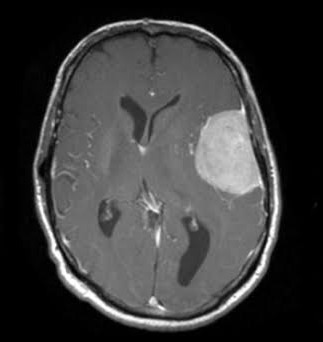

Saving GIF to output\dataset_viz.gif...


""

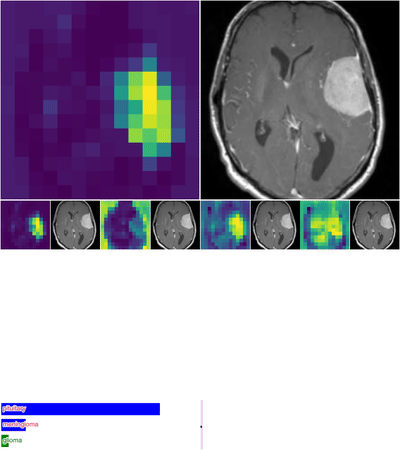

In [70]:
inference(r"dataset\val\meningioma\Te-me_0040.jpg", model)